In [ ]:
#import torch; torch.tensor([10.]*10000000000)

In [ ]:
!pip install transformers

     |████████████████████████████████| 573kB 4.7MB/s 
     |████████████████████████████████| 890kB 12.2MB/s 
     |████████████████████████████████| 3.7MB 28.8MB/s 
     |████████████████████████████████| 1.0MB 65.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=b7a920d5b66e8d0a7bc915b13bb46b9d7c8f077f3022e46b3415ac6c04876d9f
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [ ]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
path = Path('data/twitter')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data/twitter')

In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction -p {path}


  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 16.5MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 82.9MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 101MB/s]


In [ ]:
! unzip -q -n {path}/train.csv.zip -d {path}

In [ ]:
df_train = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x: str(x))
df_test['text'] = df_test['text'].apply(lambda x: str(x))
df_train['uncased_text'] = df_train['text'].apply(lambda x: x.lower())
df_test['uncased_text'] = df_test['text'].apply(lambda x: x.lower())
df_train['selected_text'] = df_train['selected_text'].apply(lambda x: str(x).lower())

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-xxlarge-v2")

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained("dbmdz/electra-large-discriminator-finetuned-conll03-english")

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained("binwang/xlnet-base-cased")

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-large")

In [ ]:
tokenizer = TransfoXLTokenizer.from_pretrained("transfo-xl-wt103")

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("ahotrod/roberta_large_squad2")

In [ ]:
df_train['tokenized_text'] = df_train['uncased_text'].apply(lambda x: tokenizer.tokenize(x, add_prefix_space=True))
df_test['tokenized_text'] = df_test['uncased_text'].apply(lambda x: tokenizer.tokenize(x, add_prefix_space=True))
df_train['tokenized_selected_text'] = df_train['selected_text'].apply(lambda x: tokenizer.tokenize(x, add_prefix_space=True))

In [ ]:
start_position_candidates = []
end_position_candidates = []
df_train['select_length'] = df_train['tokenized_selected_text'].map(len)

for i in tqdm(range(len(df_train))):
    start_position_candidate = [j for j, tok in enumerate(df_train['tokenized_text'].iloc[i]) if tok == df_train['tokenized_selected_text'].iloc[i][0]]
    end_position_candidate = [j for j, tok in enumerate(df_train['tokenized_text'].iloc[i]) if tok == df_train['tokenized_selected_text'].iloc[i][-1]]

    start_position_candidate = [idx for idx in start_position_candidate if idx + df_train['select_length'].iloc[i] - 1 in end_position_candidate]
    end_position_candidate = [idx for idx in end_position_candidate if idx - df_train['select_length'].iloc[i] + 1 in start_position_candidate]

    start_position_candidates.append(start_position_candidate)
    end_position_candidates.append(end_position_candidate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
start_position_candidates = [l[0] if len(l) > 0 else -1 for l in start_position_candidates]
end_position_candidates = [l[0] if len(l) > 0 else -1 for l in end_position_candidates]

In [ ]:
df_train['start_position'] = start_position_candidates
df_train['end_position'] = end_position_candidates
df_test['start_position'] = -1
df_test['end_position'] = -1

In [ ]:
df_train = df_train.query('start_position!=-1')

In [ ]:
len(df_train)

24888

In [ ]:
df_train.head()

textID  ... end_position
0  cb774db0d1  ...            9
1  549e992a42  ...            2
2  088c60f138  ...            5
3  9642c003ef  ...            5
4  358bd9e861  ...            3

[5 rows x 10 columns]

In [ ]:
np.max(df_train['start_position'])

33

In [ ]:
df_train['start_position'] = df_train['start_position'] + 1

In [ ]:
df_train['end_position'] = df_train['end_position'] + 1

In [ ]:
pos_train = df_train.query('sentiment=="positive"')
neg_train = df_train.query('sentiment=="negative"')
neu_train = df_train.query('sentiment=="neutral"')

In [ ]:
len(neg_train)

6674

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(5, shuffle=True, random_state=42)

In [ ]:
fold_idxs = list(kfold.split(neg_train))

In [ ]:
neg_trn_folds = {}
neg_val_folds = {}
for i, (trn_idx, val_idx) in enumerate(fold_idxs):
    neg_trn_folds['{}'.format(i)] = neg_train.iloc[trn_idx]
    neg_val_folds['{}'.format(i)] = neg_train.iloc[val_idx]


In [ ]:
neg_trn_fold_1 = neg_trn_folds['1']

In [ ]:
neg_val_fold_1 = neg_val_folds['1']

In [ ]:
neg_trn_fold_1['is_valid'] = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
neg_val_fold_1['is_valid'] = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
neg_train_1 = pd.concat([neg_trn_fold_1,neg_val_fold_1])

In [ ]:
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

In [ ]:
from transformers import AlbertForQuestionAnswering
from transformers import AlbertTokenizer
from transformers import AlbertConfig

In [ ]:
from transformers import XLNetConfig
from transformers import XLNetTokenizer
from transformers import XLNetForQuestionAnsweringSimple

In [ ]:
from transformers import ElectraConfig
from transformers import ElectraTokenizer
from transformers import ElectraModel

In [ ]:
from transformers import T5Config
from transformers import T5Tokenizer
from transformers import T5Model

In [ ]:
from transformers import TransfoXLConfig
from transformers import TransfoXLTokenizer
from transformers import TransfoXLModel

In [ ]:
from transformers import RobertaConfig
from transformers import RobertaTokenizer
from transformers import RobertaForQuestionAnswering

In [ ]:
use_fp16 = False
bs = 12

In [ ]:
model_type = 'roberta'
pretrained_model_name = "ahotrod/roberta_large_squad2"

In [ ]:
MODEL_CLASSES = {
    'albert': (AlbertForQuestionAnswering, AlbertTokenizer, AlbertConfig),
    'xlnet': (XLNetForQuestionAnsweringSimple, XLNetTokenizer, XLNetConfig),   
    'electra': (ElectraModel, ElectraTokenizer, ElectraConfig),
    't5': (T5Model, T5Tokenizer, T5Config),
    'transfo-xl': (TransfoXLModel, TransfoXLTokenizer, TransfoXLConfig),
    'roberta': (RobertaForQuestionAnswering, RobertaTokenizer, RobertaConfig)
}

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'albert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = 192
        #self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        #eos = self._pretrained_tokenizer.eos_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        if self.model_type in ['albert']:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len-2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len-2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            if self.model_type in ['t5']:
                tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len]
            if self.model_type in ['transfo-xl']:
                tokens = self._pretrained_tokenizer.tokenize(t, add_space_before_punct_symbol=True)[:self.max_seq_len]               
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
tokens = transformer_tokenizer.tokenize('I am doing so good today.', add_space_before_punct_symbol = True)
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['i', 'Ġam', 'Ġdoing', 'Ġso', 'Ġgood', 'Ġtoday', '.']
[118, 524, 608, 98, 205, 452, 4]


['i', 'Ġam', 'Ġdoing', 'Ġso', 'Ġgood', 'Ġtoday', '.']

In [ ]:
databunch = (TextList.from_df(neg_train_1, cols='text', processor=transformer_processor)
             .split_from_df(col='is_valid')
             .label_from_df(cols = ['start_position', 'end_position'])         
             .databunch(bs= 30, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
tokenize_processor.process_one('haha better drunken tweeting you mean?')

TypeError: ignored

In [ ]:
x = transformer_tokenizer.encode_plus("Hello, my dog is cute", add_space_before_punct_symbol=True)

In [ ]:
transformer_tokenizer.convert_ids_to_tokens(x['input_ids'])

['Hello', ',', 'my', 'dog', 'is', 'cute']

In [ ]:
one_batch = transformer_tokenizer.encode_plus('haha better drunken tweeting you mean?', add_space_before_punct_symbol=True)

In [ ]:
one_batch

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [24, 751, 16257, 62586, 304, 2919, 788],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}

In [ ]:
z = transformer_tokenizer.encode("Hello, my dog is cute", return_tensors="pt")

In [ ]:
x=transformer_tokenizer.tokenize('haha better drunken tweeting you mean?', add_space_before_punct_symbol=True)

In [ ]:
transformer_tokenizer.build_inputs_with_special_tokens(x)

['haha', 'better', 'drunken', 'tweeting', 'you', 'mean', '?']

In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


In [ ]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        start_scores = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]
        end_scores = self.transformer(input_ids,
                                  attention_mask = attention_mask)[1] 
        return (start_scores,end_scores)

In [ ]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model 
        self.drop_out = nn.Dropout(0.1)      
        self.l0 = nn.Linear(1024*2, 2)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
    
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=pad_idx).type(input_ids.type())
        out = self.transformer(
            input_ids = input_ids,
            decoder_input_ids = input_ids,
            attention_mask=attention_mask            
        )           
        hidden_layers = out[1] 
        out = torch.cat((hidden_layers[-1],hidden_layers[-2]), dim=-1)
        out = self.drop_out(out)
        logits = self.l0(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name)

In [ ]:
transformer_model.forward(input_ids = z.cuda(),d inputs_embeds=None)[0]

SyntaxError: ignored

In [ ]:
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial



In [ ]:
!pip install torch_optimizer

In [ ]:
import torch_optimizer as optim

In [ ]:
opt_func_QHAdam = partial(optim.QHAdam, betas=(0.95, 0.999), eps=1e-6, weight_decay=0)

In [ ]:
opt_func_Lamb = partial(optim.Lamb, betas=(0.95, 0.999), eps=1e-6, weight_decay=0)

In [ ]:
opt_func_Yogi = partial(optim.Yogi, betas=(0.95, 0.999), eps=1e-6, weight_decay=0)

In [ ]:
from over9000 import *

In [ ]:
from lookahead import Lookahead

In [ ]:
from ralamb import Ralamb

In [ ]:
from over9000 import Over9000

In [ ]:
def DBZ(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [ ]:
Opt_DBZ = partial(DBZ)

In [ ]:
from fastai.callbacks import *

In [ ]:
def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float):
  n = len(learn.data.train_dl)
  anneal_start = int(n*n_epochs*start_pct)
  anneal_end = int(n*n_epochs) - anneal_start
  phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
           TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
  sched = GeneralScheduler(learn, phases)
  learn.callbacks.append(sched)
  learn.fit(n_epochs)

In [ ]:
CustomAdamW = partial(AdamW, correct_bias=False)

In [ ]:
class LabelSmoothingCrossEntropy(Module):
    y_int = True
    def __init__(self, eps:float=0.1, reduction='mean', ignore_index = 100): self.eps,self.reduction,self.ignore_index = eps,reduction,ignore_index

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction, ignore_index = self.ignore_index)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [ ]:
def my_custom_loss(preds,targets):
    start_positions, end_positions = targets[:, 0].long(), targets[:, 1].long()
    start_logits, end_logits = preds
    ignored_index = start_logits.size(1)
    loss_fct = CrossEntropyFlat(ignore_index=ignored_index)
    #loss_fct = LabelSmoothingCrossEntropy(ignore_index=ignored_index)
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    loss = (start_loss + end_loss) / 2
    return loss

In [ ]:
neg_learner_1 = Learner(databunch, 
                  custom_transformer_model,                  
                  opt_func = Opt_DBZ,    
                  loss_func = my_custom_loss                  
                  )

In [ ]:
neg_learner_1.callbacks.append(ShowGraph(neg_learner_1))

In [ ]:
print(neg_learner_1.model)

CustomTransformerModel(
  (transformer): RobertaForQuestionAnswering(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Lin

In [ ]:
#albert
list_layers = [neg_learner_1.model.transformer.albert.embeddings,
              neg_learner_1.model.transformer.albert.encoder,               
              neg_learner_1.model.transformer.albert.pooler,
              neg_learner_1.model.transformer.qa_outputs]

In [ ]:
#xlnet
list_layers = [neg_learner_1.model.transformer.transformer.word_embedding,
              neg_learner_1.model.transformer.transformer.layer[0],
              neg_learner_1.model.transformer.transformer.layer[1],
              neg_learner_1.model.transformer.transformer.layer[2],
              neg_learner_1.model.transformer.transformer.layer[3],
              neg_learner_1.model.transformer.transformer.layer[4],
              neg_learner_1.model.transformer.transformer.layer[5],
              neg_learner_1.model.transformer.transformer.layer[6],
              neg_learner_1.model.transformer.transformer.layer[7],
              neg_learner_1.model.transformer.transformer.layer[8],
              neg_learner_1.model.transformer.transformer.layer[9],
              neg_learner_1.model.transformer.transformer.layer[10],
              neg_learner_1.model.transformer.transformer.layer[11],
              neg_learner_1.model.transformer.qa_outputs
              ]

In [ ]:
#electra
list_layers = [neg_learner_1.model.transformer.embeddings,
              neg_learner_1.model.transformer.encoder.layer[0],
              neg_learner_1.model.transformer.encoder.layer[1],
              neg_learner_1.model.transformer.encoder.layer[2],
              neg_learner_1.model.transformer.encoder.layer[3],
              neg_learner_1.model.transformer.encoder.layer[4],
              neg_learner_1.model.transformer.encoder.layer[5],
              neg_learner_1.model.transformer.encoder.layer[6],
              neg_learner_1.model.transformer.encoder.layer[7],
              neg_learner_1.model.transformer.encoder.layer[8],
              neg_learner_1.model.transformer.encoder.layer[9],
              neg_learner_1.model.transformer.encoder.layer[10],
              neg_learner_1.model.transformer.encoder.layer[11],
              neg_learner_1.model.transformer.encoder.layer[12],
              neg_learner_1.model.transformer.encoder.layer[13],
              neg_learner_1.model.transformer.encoder.layer[14],
              neg_learner_1.model.transformer.encoder.layer[15],
              neg_learner_1.model.transformer.encoder.layer[16],
              neg_learner_1.model.transformer.encoder.layer[17],
              neg_learner_1.model.transformer.encoder.layer[18],
              neg_learner_1.model.transformer.encoder.layer[19],
              neg_learner_1.model.transformer.encoder.layer[20],
              neg_learner_1.model.transformer.encoder.layer[21],
              neg_learner_1.model.transformer.encoder.layer[22],
              neg_learner_1.model.transformer.encoder.layer[23],
              neg_learner_1.model.dropout]

In [ ]:
#t5
list_layers = [neg_learner_1.model.transformer.shared,
              neg_learner_1.model.transformer.encoder.embed_tokens,
              neg_learner_1.model.transformer.encoder.block[0],
              neg_learner_1.model.transformer.encoder.block[1],
              neg_learner_1.model.transformer.encoder.block[2],
              neg_learner_1.model.transformer.encoder.block[3],
              neg_learner_1.model.transformer.encoder.block[4],
              neg_learner_1.model.transformer.encoder.block[5],
              neg_learner_1.model.transformer.encoder.block[6],
              neg_learner_1.model.transformer.encoder.block[7],
              neg_learner_1.model.transformer.encoder.block[8],
              neg_learner_1.model.transformer.encoder.block[9],
              neg_learner_1.model.transformer.encoder.block[10],
              neg_learner_1.model.transformer.encoder.block[11],
              neg_learner_1.model.transformer.encoder.block[12],
              neg_learner_1.model.transformer.encoder.block[13],
              neg_learner_1.model.transformer.encoder.block[14],
              neg_learner_1.model.transformer.encoder.block[15],
              neg_learner_1.model.transformer.encoder.block[16],
              neg_learner_1.model.transformer.encoder.block[17],
              neg_learner_1.model.transformer.encoder.block[18],
              neg_learner_1.model.transformer.encoder.block[19],
              neg_learner_1.model.transformer.encoder.block[20],
              neg_learner_1.model.transformer.encoder.block[21],
              neg_learner_1.model.transformer.encoder.block[22],
              neg_learner_1.model.transformer.encoder.block[23],
              neg_learner_1.model.drop_out]

In [ ]:
#roberta
list_layers = [neg_learner_1.model.transformer.roberta.embeddings,
              neg_learner_1.model.transformer.roberta.encoder.layer[0],
              neg_learner_1.model.transformer.roberta.encoder.layer[1],
              neg_learner_1.model.transformer.roberta.encoder.layer[2],
              neg_learner_1.model.transformer.roberta.encoder.layer[3],
              neg_learner_1.model.transformer.roberta.encoder.layer[4],
              neg_learner_1.model.transformer.roberta.encoder.layer[5],
              neg_learner_1.model.transformer.roberta.encoder.layer[6],
              neg_learner_1.model.transformer.roberta.encoder.layer[7],
              neg_learner_1.model.transformer.roberta.encoder.layer[8],
              neg_learner_1.model.transformer.roberta.encoder.layer[9],
              neg_learner_1.model.transformer.roberta.encoder.layer[10],
              neg_learner_1.model.transformer.roberta.encoder.layer[11],
              neg_learner_1.model.transformer.roberta.encoder.layer[12],
              neg_learner_1.model.transformer.roberta.encoder.layer[13],
              neg_learner_1.model.transformer.roberta.encoder.layer[14],
              neg_learner_1.model.transformer.roberta.encoder.layer[15],
              neg_learner_1.model.transformer.roberta.encoder.layer[16],
              neg_learner_1.model.transformer.roberta.encoder.layer[17],
              neg_learner_1.model.transformer.roberta.encoder.layer[18],
              neg_learner_1.model.transformer.roberta.encoder.layer[19],
              neg_learner_1.model.transformer.roberta.encoder.layer[20],
              neg_learner_1.model.transformer.roberta.encoder.layer[21],
              neg_learner_1.model.transformer.roberta.encoder.layer[22],
              neg_learner_1.model.transformer.roberta.encoder.layer[23],
              neg_learner_1.model.transformer.roberta.pooler,
              neg_learner_1.model.transformer.qa_outputs]

In [ ]:
neg_learner_1.split(list_layers)
num_groups = len(neg_learner_1.layer_groups)
print('Learner split in',num_groups,'groups')
print(neg_learner_1.layer_groups)

Learner split in 27 groups
[Sequential(
  (0): Embedding(50265, 1024, padding_idx=1)
  (1): Embedding(514, 1024, padding_idx=1)
  (2): Embedding(1, 1024)
  (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=1024, bias=True)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=1024, out_features=4096, bias=True)
  (8): Linear(in_features=4096, out_features=1024, bias=True)
  (9): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=10

In [ ]:
neg_learner_1.save('untrainneg1')

RuntimeError: ignored

In [ ]:
neg_learner_1.load('untrainneg1');

In [ ]:
neg_learner_1.split(list_layers)

Learner(data=TextClasDataBunch;

Train: LabelList (5339 items)
x: TextList
<s> Ġso oo Ġsad Ġi Ġwill Ġmiss Ġyou Ġhere Ġin Ġsan Ġdie go !!! </s>,<s> my Ġboss Ġis Ġbullying Ġme ... </s>,<s> Ġwhat Ġinterview ! Ġleave Ġme Ġalone </s>,<s> Ġsons Ġof Ġ**** , Ġwhy Ġcouldn ` t Ġthey Ġput Ġthem Ġon Ġthe Ġreleases Ġwe Ġalready Ġbought </s>,<s> my Ġsharp ie Ġis Ġrunning Ġdangerously Ġlow Ġon Ġink </s>
y: MultiCategoryList
start_position,,,start_position,
Path: .;

Valid: LabelList (1335 items)
x: TextList
<s> i ` m Ġso oooo o Ġsle ee e ep y !!! Ġthe Ġlast Ġday Ġo ` Ġschool Ġwas Ġtoday .... sn iff le .... </s>,<s> Ġpoor Ġyou Ġ Ġget Ġoutside Ġand Ġsleep Ġin Ġthe Ġgarden , Ġthe Ġsun Ġwill Ġdo Ġyou Ġgood . Ġbut Ġdon ` t Ġforget Ġsun cream !!! </s>,<s> not Ġwell </s>,<s> url Ġin Ġprevious Ġpost Ġ( to Ġtimer Ġjob ) Ġshould Ġbe Ġhttp :// bit . ly / a 4 f db . Ġi ` d Ġremoved Ġspace Ġwhich Ġmessed Ġup Ġurl . Ġ Ġ^ es </s>,<s> Ġi ` m Ġsad Ġthat Ġi Ġmissed Ġyou Ġguys Ġlast Ġnight ! </s>
y: MultiCategoryList
,

In [ ]:
neg_learner_1.to_fp16();

In [ ]:
neg_learner_1.freeze_to(-1)

In [ ]:
neg_learner_1.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [60, 1024]           51,471,360 False     
______________________________________________________________________
Embedding            [60, 1024]           526,336    False     
______________________________________________________________________
Embedding            [60, 1024]           1,024      False     
______________________________________________________________________
LayerNorm            [60, 1024]           2,048      False     
______________________________________________________________________
Dropout              [60, 1024]           0          False     
______________________________________________________________________
Linear               [60, 1024]           1,049,600  False     
______________________________________________________________________
Linear               [60, 1024]           1,049,600  False     
_______________________________________

In [ ]:
CUDA_LAUNCH_BLOCKING=0

In [ ]:
neg_learner_1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 2.29E-01


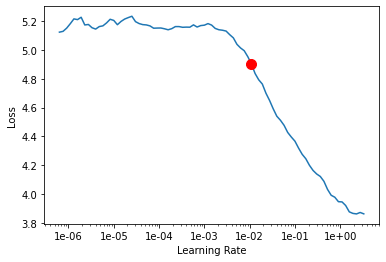

In [ ]:
neg_learner_1.recorder.plot(suggestion=True)

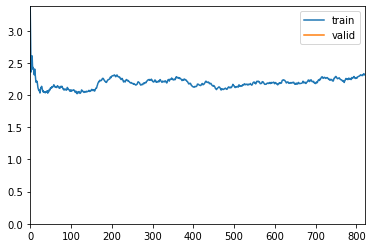

In [ ]:
#flattenAnneal(pos_learner, 2e-6, 1, 0.7)

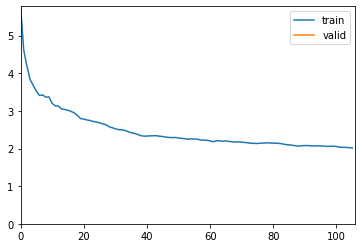

In [ ]:
neg_learner_1.fit_one_cycle(1, max_lr = 3e-1, moms=(0.8, 0.9))

In [ ]:
neg_learner_1.save('first_cycleneg1')

In [ ]:
neg_learner_1.load('first_cycleneg1');

In [ ]:
neg_learner_1.opt_func = CustomAdamW

In [ ]:
neg_learner_1.freeze_to(-6)

In [ ]:
neg_learner_1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-04
Min loss divided by 10: 6.31E-08


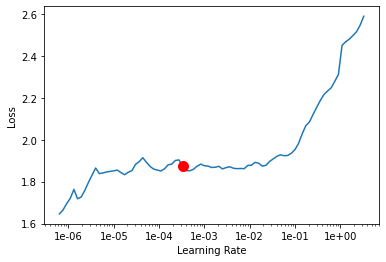

In [ ]:
neg_learner_1.recorder.plot(suggestion=True)
#plt.vlines(3e-04, 1, 2)

In [ ]:
lr = 8e-7

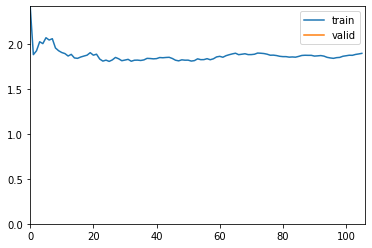

In [ ]:
neg_learner_1.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
neg_learner_1.save('second_cycleneg1')

In [ ]:
neg_learner_1.load('second_cycleneg1');

In [ ]:
neg_learner_1.freeze_to(-12)

In [ ]:
neg_learner_1.data = databunch

In [ ]:
neg_learner_1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-07


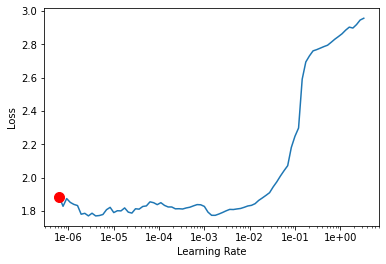

In [ ]:
neg_learner_1.recorder.plot(suggestion=True)
#plt.vlines(3e-04, 1, 2)

In [ ]:
lr = 5e-6

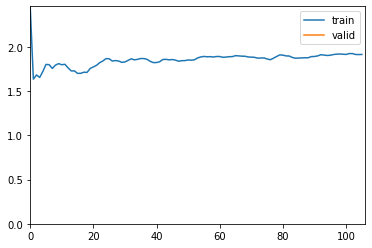

In [ ]:
neg_learner_1.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
neg_learner_1.save('third_cycleneg1')

In [ ]:
neg_learner_1.load('third_cycleneg1');

In [ ]:
neg_learner_1.unfreeze()

In [ ]:
neg_learner_1.opt_func = opt_func_Yogi

In [ ]:
neg_learner_1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.32E-05


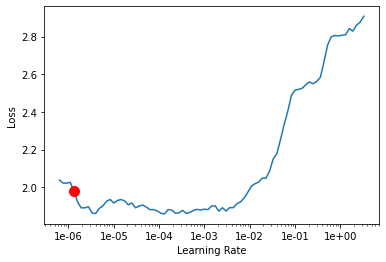

In [ ]:
neg_learner_1.recorder.plot(suggestion=True)
#plt.vlines(3e-04, 0.8, 1.8)

In [ ]:
lr = 1e-6

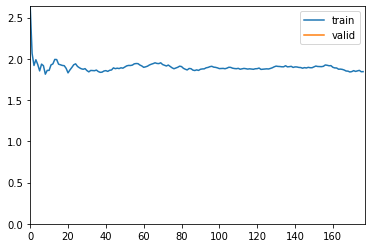

In [ ]:
neg_learner_1.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
neg_learner_1.save('unfreezeneg1')

In [ ]:
neg_learner_1.load('unfreezeneg1');

In [ ]:
def predictspecial(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
        "Return predicted class, label and probabilities for `item`."
        batch = self.data.one_item(item)
        res = self.pred_batch(batch=batch, with_dropout=with_dropout)
        raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
        ds = self.data.single_ds
        raw_pred_start = F.softmax(raw_pred[0])
        raw_pred_end = F.softmax(raw_pred[1])
        pred_start = np.argmax(raw_pred_start)
        pred_end = np.argmax(raw_pred_end)
        x = ds.x.reconstruct(grab_idx(x, 0))
        #y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
        return (x, raw_pred) if return_x else (pred_start, pred_end, raw_pred_start, raw_pred_end)

In [ ]:
predictspecial(self = neg_learner_1,item = "I`m in VA for the weekend, my youngest son turns 2 tomorrow......it makes me kinda sad, he is getting so big, check out my twipics")[0:4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


(tensor(21),
 tensor(28),
 tensor([1.5672e-03, 1.6542e-01, 1.8793e-03, 6.6945e-04, 2.0782e-03, 2.1656e-02,
         6.1914e-04, 1.6912e-03, 1.4940e-03, 2.9813e-03, 1.1257e-02, 7.2351e-03,
         2.0064e-03, 3.5803e-03, 3.4264e-03, 3.7945e-03, 1.0431e-02, 7.0042e-02,
         4.6204e-02, 2.8309e-03, 5.6170e-02, 3.8460e-01, 9.7919e-03, 1.4539e-02,
         1.0684e-02, 2.0165e-02, 1.7512e-02, 2.3576e-02, 5.7705e-03, 6.7358e-02,
         2.8952e-03, 6.1863e-03, 1.6331e-02, 3.0371e-03, 4.3903e-04, 8.2653e-05]),
 tensor([5.1746e-04, 1.0785e-03, 2.4158e-04, 1.3357e-03, 4.4347e-04, 2.3510e-03,
         2.4443e-04, 3.3550e-02, 9.8389e-04, 2.8951e-02, 1.2353e-03, 3.7679e-03,
         3.5362e-03, 2.0139e-03, 9.7542e-03, 9.5702e-03, 4.5620e-03, 1.1436e-03,
         5.9307e-03, 2.8255e-03, 7.0964e-03, 9.2275e-02, 2.0958e-01, 1.3370e-03,
         1.0933e-03, 2.7648e-03, 2.8179e-03, 1.0103e-02, 5.1066e-01, 7.0929e-03,
         5.3592e-03, 4.4636e-03, 2.0727e-03, 5.7454e-03, 2.3217e-02, 2.8857e-04])

In [ ]:
lambdalatokenizer.tokenize("I`m in VA for the weekend, my youngest son turns 2 tomorrow......it makes me kinda sad, he is getting so big, check out my twipics")[20:28]

['Ġsad', ',', 'Ġhe', 'Ġis', 'Ġgetting', 'Ġso', 'Ġbig', ',']

In [ ]:
pos_learner.show_results()

TypeError: ignored

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [ ]:
neg_test[['text']].head()

text
2   Recession hit Veronique Branquinho, she has to quit her company, such a shame!                                                    
6   I THINK EVERYONE HATES ME ON HERE   lol                                                                                           
7    soooooo wish i could, but im in school and myspace is completely blocked                                                         
10  My bike was put on hold...should have known that.... argh total bummer                                                            
13  I`m in VA for the weekend, my youngest son turns 2 tomorrow......it makes me kinda sad, he is getting so big, check out my twipics

In [ ]:
import shutil

In [ ]:
shutil.move('/content/models/unfreezeneg1.pth','/content/drive/My Drive/fastai-v3/unfreezeneg1.pth')

FileNotFoundError: ignored

In [ ]:
pos_test = df_test.query('sentiment=="positive"')
neg_test = df_test.query('sentiment=="negative"')
neu_test = df_test.query('sentiment=="neutral"')

In [ ]:
pos_end_scores = pos_test['text'].apply(lambda x: predictspecial(self = pos_learner,item = str(x))[1].item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [ ]:
neg_pred = pd.DataFrame()

In [ ]:
neg_pred['start_position'] = neg_start_scores

In [ ]:
neg_pred['end_position'] = neg_end_scores

In [ ]:
neg_pred['end_position'] = neg_pred['end_position'] - 1

In [ ]:
neg_pred['start_position'] = neg_pred['start_position'] - 1

In [ ]:
neg_pred.head()

start_position  end_position
2   0               19          
6   3               4           
7   0               16          
10  20              22          
13  25              26

In [ ]:
pos_learner.load('/content/11thre-unfreezepos0.8334');

In [ ]:
pos_pred = pd.DataFrame()

In [ ]:
pos_pred['start_position'] = pos_start_scores

In [ ]:
pos_pred['end_position'] = pos_end_scores

In [ ]:
pos_pred['end_position'] = pos_pred['end_position'] - 1

In [ ]:
pos_pred['start_position'] = pos_pred['start_position'] - 1

In [ ]:
pos_pred.head()

start_position  end_position
1   20              20          
3   0               0           
4   13              16          
5   0               4           
18  13              14

In [ ]:
count = 0
for i, s in enumerate(pos_test['tokenized_text']):
  if (pos_pred['end_position'].iloc[i] == -1):
      pos_pred['end_position'].iloc[i] = 0
      count = count+1
count

93

In [ ]:
count = 0
for i, s in enumerate(pos_test['tokenized_text']):
  if (pos_pred['end_position'].iloc[i] == len(s)):
      pos_pred['end_position'].iloc[i] = len(s) - 1
      count = count+1
count

0

In [ ]:
count = 0
for i, s in enumerate(pos_pred['end_position']):
  if (pos_pred['start_position'].iloc[i] > s):
      s = pos_pred['start_position'].iloc[i]
      count = count+1
count

21

In [ ]:
pos_pred.head()

start_position  end_position
1   20              20          
3   0               0           
4   13              16          
5   0               4           
18  13              14

In [ ]:
pos_pred.to_csv('/content/data/twitter/pos_pred.csv')

In [ ]:
neg_pred = pd.read_csv('/content/neg_pred.csv')

In [ ]:
neg_pred = neg_pred.drop('Unnamed: 0', axis = 1)

In [ ]:
neg_pred.head()

start_position  end_position
0               2             8
1               0            13
2              11            13
3               3             3
4              11            24

In [ ]:
len(neg_pred)

1001

In [ ]:
len(neg_test)

1001

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.texts = df['uncased_text'].values
        self.hash_index = df['textID'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        returns = {
            'text' : self.texts[idx],
            'idx' : idx
        }
        return returns

In [ ]:
ds_pos_test = TestDataset(pos_test)
ds_neg_test = TestDataset(neg_test)

In [ ]:
DEBUG_MODE = False

In [ ]:
df_test.index = df_test['textID']
df_test['selected_text'] = ''

df_test.loc[ds_pos_test.hash_index[:bs if DEBUG_MODE else len(df_test)], 'start_position':'end_position'] = pos_pred.values
df_test.loc[ds_neg_test.hash_index[:bs if DEBUG_MODE else len(df_test)], 'start_position':'end_position'] = neg_pred.values
df_test

textID  \
textID                   
f87dea47db  f87dea47db   
96d74cb729  96d74cb729   
eee518ae67  eee518ae67   
01082688c6  01082688c6   
33987a8ee5  33987a8ee5   
726e501993  726e501993   
261932614e  261932614e   
afa11da83f  afa11da83f   
e64208b4ef  e64208b4ef   
37bcad24ca  37bcad24ca   
24c92644a4  24c92644a4   
43b390b336  43b390b336   
69d6b5d93e  69d6b5d93e   
5c1e0b61a1  5c1e0b61a1   
504e45d9d9  504e45d9d9   
ae93ad52a0  ae93ad52a0   
9fce30159a  9fce30159a   
00d5195223  00d5195223   
33f19050cf  33f19050cf   
f7718b3c23  f7718b3c23   
9ef44428d0  9ef44428d0   
be634ebeb0  be634ebeb0   
3dcf4f7e13  3dcf4f7e13   
f0ef04109b  f0ef04109b   
8be365118e  8be365118e   
c50bdd4567  c50bdd4567   
334954f215  334954f215   
b783916431  b783916431   
1fa8e6ad66  1fa8e6ad66   
be38b29042  be38b29042   
95701e8ed9  95701e8ed9   
4dd58ecd2c  4dd58ecd2c   
cf553cccd5  cf553cccd5   
55c69c2d52  55c69c2d52   
9b1a52cc02  9b1a52cc02   
cce5c4744a  cce5c4744a   
c7f9d559e2  c7f9d559e2   
3d2478db59  3d2478db59   
6d846d7d50  6d846d7d50   
599f51af6b  599f51af6b   
87daa62920  87daa62920   
6506dc55ff  6506dc55ff   
746d87f93e  746d87f93e   
ef7ef8e474  ef7ef8e474   
d3d7b13278  d3d7b13278   
ddc07db84e  ddc07db84e   
67afe60d31  67afe60d31   
17d18ba9ef  17d18ba9ef   
ab57d75f20  ab57d75f20   
f0acd25d8e  f0acd25d8e   
cf3b068b03  cf3b068b03   
d6c34fa875  d6c34fa875   
614aed9113  614aed9113   
dfa577d3c1  dfa577d3c1   
10dcbe4dfb  10dcbe4dfb   
a0bfb12773  a0bfb12773   
71f4a9b495  71f4a9b495   
d33ed264b3  d33ed264b3   
77f88ea9e2  77f88ea9e2   
fe1deac869  fe1deac869   
e591a725ef  e591a725ef   
2dbb28cc29  2dbb28cc29   
a7e4ad250a  a7e4ad250a   
7d87899024  7d87899024   
461b51fa58  461b51fa58   
c31d79c440  c31d79c440   
32ee7ef6c2  32ee7ef6c2   
29f805a7d2  29f805a7d2   
d41fe360e4  d41fe360e4   
a04c8c8695  a04c8c8695   
25e42b2bf2  25e42b2bf2   
5843d17b1d  5843d17b1d   
474d10ff48  474d10ff48   
38e69da3a1  38e69da3a1   
972dc5787d  972dc5787d   
0ba6aaf9aa  0ba6aaf9aa   
7a81537034  7a81537034   
311d2b185b  311d2b185b   
1e46d72ec6  1e46d72ec6   
390f169584  390f169584   
58129e4130  58129e4130   
e6c9e5e3ab  e6c9e5e3ab   
cb5e709de8  cb5e709de8   
a14b4ff440  a14b4ff440   
5d57a5eda2  5d57a5eda2   
1e3561e921  1e3561e921   
c2ea5cb58b  c2ea5cb58b   
cde0016d6d  cde0016d6d   
5fc411e8d1  5fc411e8d1   
5ffb19ae8f  5ffb19ae8f   
76da985a47  76da985a47   
3a98aa4762  3a98aa4762   
886545bbab  886545bbab   
2afe118dc3  2afe118dc3   
704c53f4cf  704c53f4cf   
71fa60d9ff  71fa60d9ff   
c238c4dbb7  c238c4dbb7   
dc73e85417  dc73e85417   
af63915fa9  af63915fa9   
eb2fc4d281  eb2fc4d281   
f9382a1f7b  f9382a1f7b   
54670ca807  54670ca807   
3ab338c459  3ab338c459   
c7c7f7f025  c7c7f7f025   
1256e6a4d2  1256e6a4d2   
990cdeae87  990cdeae87   
9a55d83c79  9a55d83c79   
c8307a482d  c8307a482d   
0a21b662a4  0a21b662a4   
297f7d9e0f  297f7d9e0f   
68901906a4  68901906a4   
3112944847  3112944847   
8f8334ffa2  8f8334ffa2   
322546026e  322546026e   
e6c154f9be  e6c154f9be   
e96d849b35  e96d849b35   
124e30d941  124e30d941   
fbb5742bbb  fbb5742bbb   
e90acf3c42  e90acf3c42   
0b0944285d  0b0944285d   
a11da2d3bf  a11da2d3bf   
161bfc7c8a  161bfc7c8a   
4a65010643  4a65010643   
1b460c82f0  1b460c82f0   
43e91a5488  43e91a5488   
410dd99aa3  410dd99aa3   
b3eadfc565  b3eadfc565   
480894125b  480894125b   
001617fca4  001617fca4   
52f2f23473  52f2f23473   
e7e27b0c91  e7e27b0c91   
834dc73c0c  834dc73c0c   
aeb0e9d730  aeb0e9d730   
c672c9da1d  c672c9da1d   
cbee1946d3  cbee1946d3   
b1999f0951  b1999f0951   
25510fbf89  25510fbf89   
bcb9426abb  bcb9426abb   
0d29624200  0d29624200   
3f0f5891ab  3f0f5891ab   
0b34e66ea3  0b34e66ea3   
11de8c0456  11de8c0456   
d5712716e9  d5712716e9   
3f90f95beb  3f90f95beb   
c108e09b19  c108e09b19   
7223fdccc2  7223fdccc2   
f254748cdb  f254748cdb   
256453d14f  256453d14f   
8fd01857a9  8fd01857a9   
37227c0dbf  37227c0dbf   
20aff2fcb1  20aff2fcb1   
ca223af36e  ca223af36e   
90977e9614  

In [ ]:
for i in tqdm(range(len(df_test))):
    if df_test['sentiment'].iloc[i] in ('positive', 'negative'):
        tokenized_text = df_test['tokenized_text'].iloc[i]
        start_position = max(df_test['start_position'].iloc[i], 0)
        end_position = min(df_test['end_position'].iloc[i], len(tokenized_text) - 1)
        
        # restore original text
        selected_text = tokenizer.convert_tokens_to_string(tokenized_text[start_position : end_position + 1])
        for original_token in df_test['text'].iloc[i].split():
            tokenized_form = tokenizer.convert_tokens_to_string(tokenizer.tokenize(original_token))
            selected_text = selected_text.replace(tokenized_form, original_token, 1)
        
        df_test['selected_text'].iloc[i] = selected_text

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
for i in tqdm(range(len(df_test))):
    if df_test['sentiment'].iloc[i] == 'neutral':
        df_test['selected_text'].iloc[i] = df_test['text'].iloc[i]
    else:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
df_test.loc[:, ['textID', 'selected_text']]

textID  \
textID                   
f87dea47db  f87dea47db   
96d74cb729  96d74cb729   
eee518ae67  eee518ae67   
01082688c6  01082688c6   
33987a8ee5  33987a8ee5   
726e501993  726e501993   
261932614e  261932614e   
afa11da83f  afa11da83f   
e64208b4ef  e64208b4ef   
37bcad24ca  37bcad24ca   
24c92644a4  24c92644a4   
43b390b336  43b390b336   
69d6b5d93e  69d6b5d93e   
5c1e0b61a1  5c1e0b61a1   
504e45d9d9  504e45d9d9   
ae93ad52a0  ae93ad52a0   
9fce30159a  9fce30159a   
00d5195223  00d5195223   
33f19050cf  33f19050cf   
f7718b3c23  f7718b3c23   
9ef44428d0  9ef44428d0   
be634ebeb0  be634ebeb0   
3dcf4f7e13  3dcf4f7e13   
f0ef04109b  f0ef04109b   
8be365118e  8be365118e   
c50bdd4567  c50bdd4567   
334954f215  334954f215   
b783916431  b783916431   
1fa8e6ad66  1fa8e6ad66   
be38b29042  be38b29042   
95701e8ed9  95701e8ed9   
4dd58ecd2c  4dd58ecd2c   
cf553cccd5  cf553cccd5   
55c69c2d52  55c69c2d52   
9b1a52cc02  9b1a52cc02   
cce5c4744a  cce5c4744a   
c7f9d559e2  c7f9d559e2   
3d2478db59  3d2478db59   
6d846d7d50  6d846d7d50   
599f51af6b  599f51af6b   
87daa62920  87daa62920   
6506dc55ff  6506dc55ff   
746d87f93e  746d87f93e   
ef7ef8e474  ef7ef8e474   
d3d7b13278  d3d7b13278   
ddc07db84e  ddc07db84e   
67afe60d31  67afe60d31   
17d18ba9ef  17d18ba9ef   
ab57d75f20  ab57d75f20   
f0acd25d8e  f0acd25d8e   
cf3b068b03  cf3b068b03   
d6c34fa875  d6c34fa875   
614aed9113  614aed9113   
dfa577d3c1  dfa577d3c1   
10dcbe4dfb  10dcbe4dfb   
a0bfb12773  a0bfb12773   
71f4a9b495  71f4a9b495   
d33ed264b3  d33ed264b3   
77f88ea9e2  77f88ea9e2   
fe1deac869  fe1deac869   
e591a725ef  e591a725ef   
2dbb28cc29  2dbb28cc29   
a7e4ad250a  a7e4ad250a   
7d87899024  7d87899024   
461b51fa58  461b51fa58   
c31d79c440  c31d79c440   
32ee7ef6c2  32ee7ef6c2   
29f805a7d2  29f805a7d2   
d41fe360e4  d41fe360e4   
a04c8c8695  a04c8c8695   
25e42b2bf2  25e42b2bf2   
5843d17b1d  5843d17b1d   
474d10ff48  474d10ff48   
38e69da3a1  38e69da3a1   
972dc5787d  972dc5787d   
0ba6aaf9aa  0ba6aaf9aa   
7a81537034  7a81537034   
311d2b185b  311d2b185b   
1e46d72ec6  1e46d72ec6   
390f169584  390f169584   
58129e4130  58129e4130   
e6c9e5e3ab  e6c9e5e3ab   
cb5e709de8  cb5e709de8   
a14b4ff440  a14b4ff440   
5d57a5eda2  5d57a5eda2   
1e3561e921  1e3561e921   
c2ea5cb58b  c2ea5cb58b   
cde0016d6d  cde0016d6d   
5fc411e8d1  5fc411e8d1   
5ffb19ae8f  5ffb19ae8f   
76da985a47  76da985a47   
3a98aa4762  3a98aa4762   
886545bbab  886545bbab   
2afe118dc3  2afe118dc3   
704c53f4cf  704c53f4cf   
71fa60d9ff  71fa60d9ff   
c238c4dbb7  c238c4dbb7   
dc73e85417  dc73e85417   
af63915fa9  af63915fa9   
eb2fc4d281  eb2fc4d281   
f9382a1f7b  f9382a1f7b   
54670ca807  54670ca807   
3ab338c459  3ab338c459   
c7c7f7f025  c7c7f7f025   
1256e6a4d2  1256e6a4d2   
990cdeae87  990cdeae87   
9a55d83c79  9a55d83c79   
c8307a482d  c8307a482d   
0a21b662a4  0a21b662a4   
297f7d9e0f  297f7d9e0f   
68901906a4  68901906a4   
3112944847  3112944847   
8f8334ffa2  8f8334ffa2   
322546026e  322546026e   
e6c154f9be  e6c154f9be   
e96d849b35  e96d849b35   
124e30d941  124e30d941   
fbb5742bbb  fbb5742bbb   
e90acf3c42  e90acf3c42   
0b0944285d  0b0944285d   
a11da2d3bf  a11da2d3bf   
161bfc7c8a  161bfc7c8a   
4a65010643  4a65010643   
1b460c82f0  1b460c82f0   
43e91a5488  43e91a5488   
410dd99aa3  410dd99aa3   
b3eadfc565  b3eadfc565   
480894125b  480894125b   
001617fca4  001617fca4   
52f2f23473  52f2f23473   
e7e27b0c91  e7e27b0c91   
834dc73c0c  834dc73c0c   
aeb0e9d730  aeb0e9d730   
c672c9da1d  c672c9da1d   
cbee1946d3  cbee1946d3   
b1999f0951  b1999f0951   
25510fbf89  25510fbf89   
bcb9426abb  bcb9426abb   
0d29624200  0d29624200   
3f0f5891ab  3f0f5891ab   
0b34e66ea3  0b34e66ea3   
11de8c0456  11de8c0456   
d5712716e9  d5712716e9   
3f90f95beb  3f90f95beb   
c108e09b19  c108e09b19   
7223fdccc2  7223fdccc2   
f254748cdb  f254748cdb   
256453d14f  256453d14f   
8fd01857a9  8fd01857a9   
37227c0dbf  37227c0dbf   
20aff2fcb1  20aff2fcb1   
ca223af36e  ca223af36e   
90977e9614  

In [ ]:
df_test.loc[:, ['textID', 'selected_text']].to_csv('submission.csv', index=False)

In [ ]:
databunch.dl

<bound method DataBunch.dl of TextClasDataBunch;

Train: LabelList (6575 items)
x: TextList
▁oh ! ▁good ▁idea ▁about ▁putting ▁them ▁on ▁ice ▁cream,▁ha ha ▁better ▁drunken ▁tweet ing ▁you ▁mean ?,▁had ▁an ▁ aw some ▁salad ! ▁i ▁recommend ▁getting ▁the ▁spice y ▁buffalo ▁chicken ▁salad !,▁fine ! ▁going ▁to ▁do ▁my ▁big ▁walk ▁today ▁20 ▁or ▁so ▁miles,▁thank ▁a ▁yo ou ▁how ▁are ▁you ? ▁# t witt er take over
y: MultiCategoryList
,,,end_position,
Path: .;

Valid: LabelList (730 items)
x: TextList
▁italy ▁or ▁greece ▁for ▁me ▁love ▁italian ▁men ▁he he ▁ ; ),▁happy ▁friday ! ▁do ▁u ▁know ▁how ▁i ▁can ▁get ▁a ▁copy ▁of ▁the ▁b t ▁art ▁u ▁did ▁on ▁mel ' s ▁fake ▁twitter ? ▁i ' m ▁ n ▁it , ▁but ▁can ' t ▁find ▁it ▁now . ▁ th x,▁great !,▁oh ▁god ▁they ' re ▁breaking ▁down ▁so ▁much ▁plaster ▁what ▁are ▁they ▁doing ▁in ▁there ▁i ▁like ▁walls , ▁thanks !,▁amazing , ▁my ▁brand ▁new ▁pari ▁neb ▁broke . ▁go ▁figure . ▁and ▁it ' s ▁the ▁weekend . ▁looks ▁like ▁i ▁won ' t ▁be ▁getting ▁another ▁one ▁un

In [ ]:
pos_learner.data.one_batch()[1][:,1].dtype

torch.float32

In [ ]:
pos_learner.data.one_batch()[1]

tensor([[ 0.,  3.],
        [41., 43.],
        [13., 13.],
        [ 0., 39.],
        [ 0.,  0.],
        [35., 35.],
        [ 7.,  8.],
        [31., 33.]])

In [ ]:
pos_learner.pred_batch()[0].size()

torch.Size([8, 58])